In [3]:
from scipy.sparse import *
import numpy as np
import pickle
import random
from sklearn.decomposition import PCA
%matplotlib inline
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from operator import itemgetter
from scipy.sparse import csc_matrix as smatrix
import scipy
from scipy.sparse import *
from keras.models import Sequential
from keras.layers import Dense
from sklearn.neural_network import MLPClassifier
import pandas as pd

In [14]:
def get_words(filename):
    data = open(filename, 'rb')
    res = []
    for line in tqdm(data):
        line = line.strip().decode("utf-8").split(' ')
        res += line
    return list(set(res))

In [15]:
def get_vocab(words_pos, words_neg):
    all_words = list(set(words_pos + words_neg))
    return {x: i for i, x in tqdm(enumerate(all_words))}

In [16]:
# file -> [[word_number_1_1, ..., word_number_1_K1], ..., [word_number_L_1, ..., word_number_L_KL]]
def file_to_word2numbers(filename, vocab):
    data = open(filename, 'rb')
    word2numbers_all = []
    for line in tqdm(data):
        line = line.strip().decode("utf-8").split(' ')
        word2numbers = []
        for word in line:
            if word in vocab: word2numbers.append(vocab[word])
        if word2numbers:
            word2numbers_all.append(word2numbers)
    return word2numbers_all

In [17]:
# number of word occurences as embeddings (basic embeddings)
def numbers_to_dataset(numbers, vocab):
    arr = {}
    for i, tweet in tqdm(enumerate(numbers)):
        for number in tweet:
            p = (i, number)
            if p in arr: arr[p] += 1
            else: arr[p] = 1
                    
    keys = list(arr.keys())
    values = [arr[k] for k in keys]
    return coo_matrix((values, ([x for x, y in keys], [y for x, y in keys])), shape=(len(numbers), len(vocab)))

In [18]:
# constructing X, y pair
def two_datasets_to_one(pos_data, neg_data):
    assert pos_data.shape[1] == neg_data.shape[1]
    X = scipy.sparse.vstack((pos_data, neg_data))
    y = np.array([1] * pos_data.shape[0] + [0] * neg_data.shape[0])
    assert len(y) == X.shape[0]
    assert X.shape[0] == pos_data.shape[0] + neg_data.shape[0]
    assert X.shape[1] == pos_data.shape[1]
    return X, y

In [19]:
def get_dataset(tweets_pos, tweets_neg):
    words_pos = get_words(tweets_pos)
    words_neg = get_words(tweets_neg)
    
    vocab = get_vocab(words_pos, words_neg)
    
    # construct num -> word dict
    reverse_dictionary = dict(zip(vocab.values(), vocab.keys()))
    
    # loading data -> numbers of words
    pos_numbers = file_to_word2numbers(tweets_pos, vocab)
    neg_numbers = file_to_word2numbers(tweets_neg, vocab)
    
    # applying it to numbers
    pos_data = numbers_to_dataset(pos_numbers, vocab)
    neg_data = numbers_to_dataset(neg_numbers, vocab)
    
    # applying to datasets (pos & neg)
    X, Y = two_datasets_to_one(pos_data, neg_data)
    return vocab, reverse_dictionary, X, Y

In [20]:
#vocab_full, rev_full, X_full, Y_full = get_dataset('../data/train_pos_full.txt', '../data/train_neg_full.txt')

In [21]:
vocab_part, rev_part, X_part, Y_part = get_dataset('../data/train_pos.txt', '../data/train_neg.txt')

100000it [00:00, 508576.17it/s]
100000it [00:00, 470947.86it/s]
114428it [00:00, 1182563.64it/s]
100000it [00:00, 107682.99it/s]
100000it [00:01, 91602.93it/s]
100000it [00:00, 111977.28it/s]
100000it [00:01, 95400.63it/s]


In [22]:
vocab, reverse_dictionary, X, Y = vocab_part, rev_part, X_part, Y_part
#vocab, reverse_dictionary, X, Y = vocab_full, rev_full, X_full, Y_full

In [23]:
from sklearn.model_selection import train_test_split
x, x_val, y, y_val = train_test_split(X, Y, test_size=0.01, random_state=42)

In [24]:
def batch_generator(X, y, batch_size):
    number_of_batches = steps_per_epoch
    counter = 0
    shuffle_index = np.arange(np.shape(y)[0])
    np.random.shuffle(shuffle_index)
    X =  X[shuffle_index, :]
    y =  y[shuffle_index]
    while 1:
        index_batch = shuffle_index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X[index_batch,:].todense()
        y_batch = y[index_batch]
        counter += 1
        yield(np.array(X_batch),y_batch)
        if (counter >= number_of_batches):
            np.random.shuffle(shuffle_index)
            counter = 0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7f12ecf748>]], dtype=object)

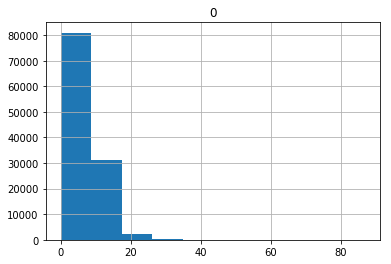

In [28]:
lengths = [len(x) for x in vocabulary.keys()]
pd.DataFrame(lengths).hist()

In [ ]:
# training LR on dataset

# use only part of training dataset
#idx = np.random.choice(range(X_train.shape[0]), 100000)
idx = list(range(x.shape[0]))
clf = LogisticRegression(verbose=True, n_jobs = 8, solver = 'newton-cg', tol = 1e-2, C = 1e5, max_iter = 100000)
#clf = MLPClassifier(verbose=True, solver='lbfgs', alpha=1e-6, hidden_layer_sizes=(100, 50), random_state=1)
clf.fit(x[idx,:], y[idx])

In [35]:
# training MLP on dataset

# use only part of training dataset
#idx = np.random.choice(range(X_train.shape[0]), 100000)
idx = list(range(x.shape[0]))
#clf = LogisticRegression(verbose=True, n_jobs = 8, solver = 'newton-cg', tol = 1e-4, C = 1e5, max_iter = 100000)
clf_mlp = MLPClassifier(verbose=True, solver='lbfgs', alpha=1e-6, hidden_layer_sizes=(100, 50), random_state=1)
clf_mlp.fit(x[idx,:], y[idx])

MLPClassifier(activation='relu', alpha=1e-06, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 50), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=True,
       warm_start=False)

In [36]:
clf=clf_mlp

In [37]:
# logistic regression with L1 and L2 regularization
from keras.regularizers import l2

reg = l2(0.01)

model = Sequential()
model.add(Dense(1, activation='sigmoid', kernel_regularizer=reg, input_dim=x.shape[1]))
model.compile(optimizer='rmsprop', loss='binary_crossentropy')
#model.fit(x, y, nb_epoch=10, validation_data=(x_val, y_val))
batch_size = 1000
nb_epoch = 10
steps_per_epoch = x.shape[0] / batch_size
generator=batch_generator(x, y, batch_size)
#model.fit_generator(generator=generator,epochs=nb_epoch, 
#                    steps_per_epoch=steps_per_epoch)

In [38]:
# print resulting loss
print(clf.score(x, y))
print(clf.score(x_val, y_val))

0.96998989899
0.8215


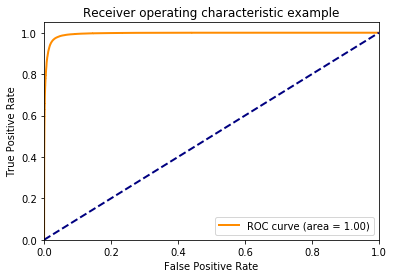

In [39]:
fpr, tpr, _ = roc_curve(y, clf.predict_proba(x)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [43]:
# open train and predict
def test_to_dataset(filename):
    data = open(filename, 'rb')
    idxes = []
    tweets_embeddings = []
    
    for line in tqdm(data):
        idx, line = line.strip().decode("utf-8").split(',', 1)
        idxes.append(idx)
        line = line.split(' ')
        tweet = []
        
        tweet_embeddings = np.zeros((len(vocab), ), dtype=np.float32)
        
        for word in line:
            if word in vocab:
                tweet_embeddings[vocab[word]] += 1
                
        tweets_embeddings.append(tweet_embeddings)
        
    #return tweets_embeddings
    tweets_embeddings = np.array(tweets_embeddings)
    assert len(idxes) == tweets_embeddings.shape[0]
    assert tweets_embeddings.shape[1] == len(vocab)
    return idxes, tweets_embeddings

In [ ]:
idx_test, X_test = test_to_dataset('../data/test_data.txt')

10000it [00:01, 5377.98it/s]


In [ ]:
y_predicted = np.array(2 * (clf.predict(X_test) - 0.5), dtype=np.int64)

In [ ]:
answers = sorted(zip(idx_test, y_predicted), key = lambda x: int(x[0]))

In [ ]:
f = open('submission_count_cleaned.txt', 'w')
f.write("Id,Prediction\n")
for idx, ans in answers:
    f.write("%s,%s\n" % (idx, ans))
f.close()